<a href="https://colab.research.google.com/github/taegukang35/device_for_blind/blob/main/warp_with_pointclouds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset
> We made Semantic Hallway Dataset downloads available segments.ai or kaggle

*  https://segments.ai/prgmti1/school_hallway/
*  https://segments.ai/prgmti1/school_hallway_ver2/
* integrated ver:  https://www.kaggle.com/taegukang0305/semantic-hallway-dataset


In [2]:
!git clone https://github.com/taegukang35/device_for_blind

Cloning into 'device_for_blind'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 69 (delta 25), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (69/69), done.


In [3]:
import json
import urllib.request
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

This example shows how to get dataset from segments.ai

In [16]:
base_dir = '/content'
images_dir = os.path.join(base_dir,'images')
#os.mkdir(images_dir)


def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype='uint8')
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  return image

#https://segments.ai/prgmti1/school_hallway_v2/releases 에서 받은 v.01 json 파일 
with open('/content/device_for_blind/school_hallway_ver2-v0.1','r') as f:
  dataset = json.load(f) 

for i in range(350,400):
    img_url = dataset['dataset']['samples'][i]['attributes']['image']['url']
    img_name = dataset['dataset']['samples'][i]['name']
    img = url_to_image(img_url)
    cv2.imwrite(os.path.join(images_dir,img_name),img)

# Depth Estimation

> model results: https://www.youtube.com/watch?v=p8Vm0s8-S_Y&ab_channel=TaeguKang



In [ ]:
!pip install tensorflow tensorflow-hub opencv-python matplotlib

In [6]:
import tensorflow as tf
import tensorflow_hub as hub

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    #tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.experimental.set_virtual_device_configuration(gpu,
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
# load model
module = hub.load("https://tfhub.dev/intel/midas/v2_1_small/1", tags=['serve'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [8]:
# https://tfhub.dev/intel/midas/v2/2
def predict_depth(IMG_PATH):
    # input
    img = cv2.imread(IMG_PATH)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

    img_resized = tf.image.resize(img, [256,256], method='bicubic', preserve_aspect_ratio=False)
    img_resized = tf.transpose(img_resized, [2, 0, 1])
    img_input = img_resized.numpy()
    reshape_img = img_input.reshape(1,3,256,256)
    tensor = tf.convert_to_tensor(reshape_img, dtype=tf.float32)

    output = module.signatures['serving_default'](tensor)
    prediction = output['default'].numpy()
    prediction = prediction.reshape(256, 256)
                
    # output file
    prediction = cv2.resize(prediction, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    #print(" Write image to: output.png")
    depth_min = prediction.min()
    depth_max = prediction.max()
    # for return depth image
    img_out = (255 * (prediction - depth_min) / (depth_max - depth_min)).astype("uint8")
    
    #cv2.imwrite("output.png", img_out)
    #plt.imshow(img_out,cmap='magma')
    return prediction,img_out
    # plt.show()

(1080, 1920)


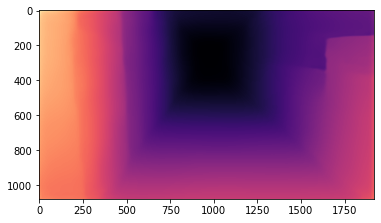

In [17]:
img_path = '/content/images/320.jpg'
depth,img_depth = predict_depth(img_path)
plt.imshow(img_depth,cmap='magma')
print(depth.shape)

In [18]:
print(depth.min(),depth.max())

7.014165 1420.8455


#Semantic Segmentation




> model results: https://www.youtube.com/watch?v=YziqwVMmjaY&ab_channel=TaeguKang







In [19]:
from keras.models import Model, load_model
seg_model = load_model('/content/device_for_blind/model-best-unet.h5')

In [20]:
def predict_mask(img_path):
    # input
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
    img_resized = tf.image.resize(img, (256, 256) ,method='bicubic', preserve_aspect_ratio=False)
    img_resized = img_resized.numpy()
    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR)

    img_input = np.expand_dims(img_resized,axis=0)
    tensor = tf.convert_to_tensor(img_input, dtype=tf.float32)
    mask = seg_model.predict(tensor)

    # Image Thresholding
    threshold = 0.8
    _, mask = cv2.threshold(mask[0][...,0], threshold * mask[0][...,0].max(), 1, cv2.THRESH_BINARY)
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
    #plt.imshow(mask)
    return mask

##Get depth map of hallway (or Stair)




In [21]:
def get_depth(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    depth,img_depth = predict_depth(img_path)
    mask = predict_mask(img_path)
    hallway_depth = depth*mask

    # erase
    fig = plt.figure(figsize=(15,15))     
    rows = 1
    cols = 3
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(img)
    ax1.set_title('Image')
    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(img_depth,cmap='magma')
    ax2.set_title('Depth')
    ax2.axis("off")
    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(hallway_depth,cmap='magma')
    ax3.set_title('Extracted Depth')
    ax3.axis("off")
    
    return hallway_depth

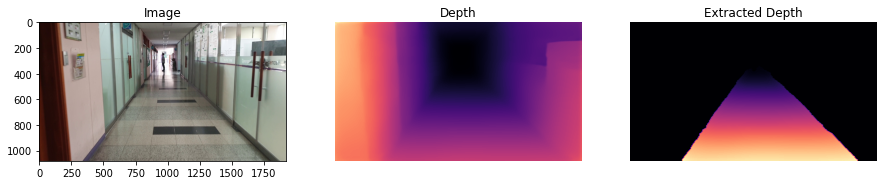

In [27]:
_ = get_depth('/content/images/320.jpg')

## From depth map to point cloud
: https://medium.com/yodayoda/from-depth-map-to-point-cloud-7473721d3f
> (u,v,depth) -> (x,y,z)



In [28]:
class Projection:
    def __init__(self, cx, cy, fx, fy, pxToMetre):
        self.cx = cx
        self.cy = cy
        self.fx = fx
        self.fy = fy
        self.pxToMetre = pxToMetre

    def convert_from_uvd(self, u, v, d):
        d *= self.pxToMetre
        x_over_z = (self.cx - u) / self.fx
        y_over_z = (self.cy - v) / self.fy
        z = d / np.sqrt(1. + x_over_z**2 + y_over_z**2)
        x = x_over_z * z
        y = y_over_z * z
        return int(x),int(y),int(z)
    
    def match_point(self,u,v,depth:np.ndarray):
        x,y,z = self.convert_from_uvd(u,v,1210 - depth[u][v])
        return x,y,z

    def run(self, seg: np.ndarray, depth: np.ndarray):
        points = []
        for i in range(int(2*self.cx)):
            for j in range(int(2*self.cy)):
                if seg[i][j] ==1:
                    points.append((self.convert_from_uvd(i,j,1420-depth[i][j])))
        return points

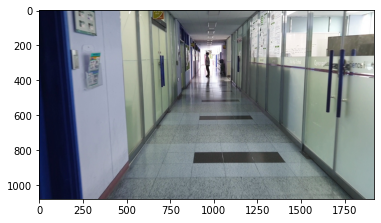

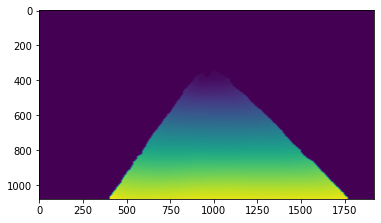

In [29]:
img_path = '/content/images/320.jpg'
img = cv2.imread(img_path)
plt.imshow(img)

depth,_ = predict_depth(img_path)
mask = predict_mask(img_path)
plt.show()
plt.imshow(mask*depth)

P = Projection(img.shape[0]/2,img.shape[1]/2,260,260,1)
point_clouds = P.run(mask,depth)

In [19]:
X,Y,Z = [i[0] for i in point_clouds],[i[1] for i in point_clouds],[i[2] for i in point_clouds]

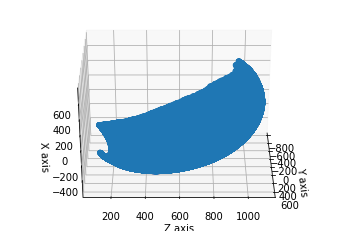

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 0)
ax.set_xlabel('Y axis')
ax.set_ylabel('Z axis')
ax.set_zlabel('X axis')
ax.scatter(Y,Z,X)

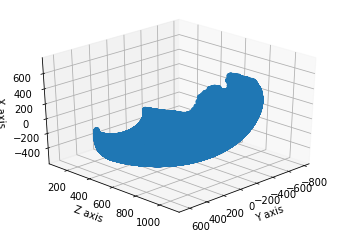

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 45)
ax.set_xlabel('Y axis')
ax.set_ylabel('Z axis')
ax.set_zlabel('X axis')
ax.scatter(Y,Z,X)

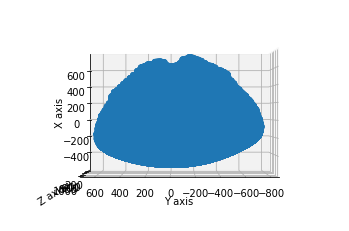

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(0, 90)
ax.set_xlabel('Y axis')
ax.set_ylabel('Z axis')
ax.set_zlabel('X axis')
ax.scatter(Y,Z,X)

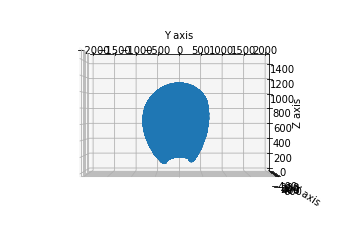

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(90, 270)
ax.set_xlim(-2000, 2000)
ax.set_ylim(0, 1500)
ax.set_xlabel('Y axis')
ax.set_ylabel('Z axis')
ax.set_zlabel('X axis')
ax.scatter(Y,Z,X)

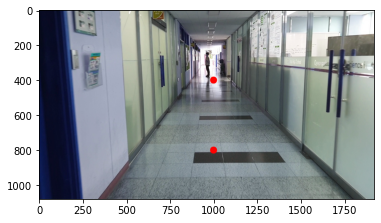

In [58]:
img = cv2.imread(img_path)
cv2.circle(img, (1000, 400), 20, (255, 0 ,0), -1)
cv2.circle(img,(1000,800),20,(255,0,0),-1)
plt.imshow(img)

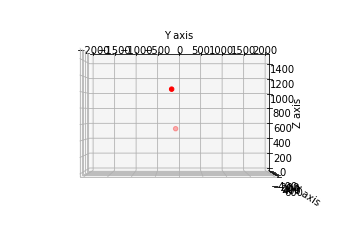

In [60]:
px = []
py = []
pz = []

x,y,z= P.match_point(400,1000,depth=depth)
px.append(x)
py.append(y)
pz.append(z)
x,y,z= P.match_point(800,1000,depth=depth)
px.append(x)
py.append(y)
pz.append(z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(90, 270)
ax.set_xlabel('Y axis')
ax.set_ylabel('Z axis')
ax.set_zlabel('X axis')
ax.set_xlim(-2000, 2000)
ax.set_ylim(0, 1500)
ax.scatter(py,pz,px, c='red')

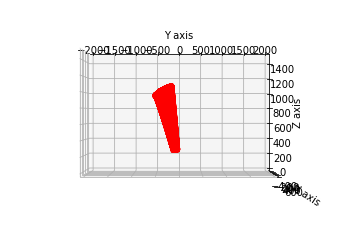

In [49]:
px = []
py = []
pz = []
for i in range(400,1000):
    for j in range(1000,1100):
        if mask[i][j]==1:
            x,y,z= P.match_point(i,j,depth=depth)
            px.append(x)
            py.append(y)
            pz.append(z)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(90, 270)
ax.set_xlabel('Y axis')
ax.set_ylabel('Z axis')
ax.set_zlabel('X axis')
ax.set_xlim(-2000, 2000)
ax.set_ylim(0, 1500)
ax.scatter(py,pz,px, c='red')

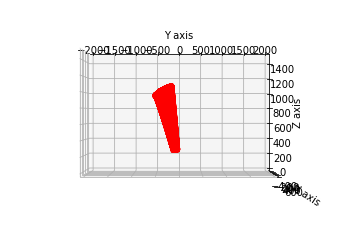

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(90, 270)
ax.set_xlabel('Y axis')
ax.set_ylabel('Z axis')
ax.set_zlabel('X axis')
ax.set_xlim(-2000, 2000)
ax.set_ylim(0, 1500)
ax.scatter(py,pz,px, c='red')

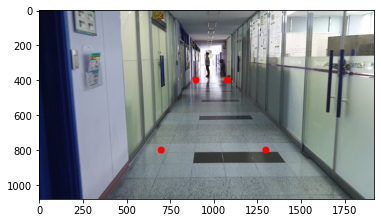

In [70]:
img = cv2.imread(img_path)
cv2.circle(img, (900, 400), 20, (255, 0 ,0), -1)
cv2.circle(img,(1080,400),20,(255,0,0),-1)
cv2.circle(img,(700,800),20,(255,0,0),-1)
cv2.circle(img,(1300,800),20,(255,0,0),-1)
plt.imshow(img)

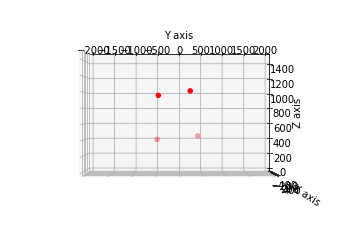

In [74]:
px = []
py = []
pz = []
points = [(400,900),(400,1080),(800,700),(800,1300)]
for point in points:
    x,y,z= P.match_point(point[0],point[1],depth=depth)
    px.append(x)
    py.append(y)
    pz.append(z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(90, 270)
ax.set_xlabel('Y axis')
ax.set_ylabel('Z axis')
ax.set_zlabel('X axis')
ax.set_xlim(-2000, 2000)
ax.set_ylim(0, 1500)
ax.scatter(py,pz,px, c='red')

# Warping Transform with Point Clouds

In [428]:
class Projection:
    def __init__(self, cx, cy, fx, fy, pxToMetre):
        self.cx = cx
        self.cy = cy
        self.fx = fx
        self.fy = fy
        self.pxToMetre = pxToMetre

    def convert_from_uvd(self, u, v, d):
        d *= self.pxToMetre
        x_over_z = (self.cx - u) / self.fx
        y_over_z = (self.cy - v) / self.fy
        z = d / np.sqrt(1. + x_over_z**2 + y_over_z**2)
        x = x_over_z * z
        y = y_over_z * z
        return int(x),int(y),int(z)
    
    def match_point(self,u,v,depth:np.ndarray):
        x,y,z = self.convert_from_uvd(u,v,depth[u][v])
        return x,y,z

    def run(self, seg: np.ndarray, depth: np.ndarray):
        points = []
        for i in range(int(2*self.cx)):
            for j in range(int(2*self.cy)):
                if seg[i][j] ==1:
                    points.append((self.convert_from_uvd(i,j,depth[i][j])))
        return points

In [412]:
## find four suitable points 
def find_points(mask:np.ndarray): 
    thresholded_mask = cv2.convertScaleAbs(mask)
    contours, _ = cv2.findContours(thresholded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print('number of contours:',len(contours))
    contour_areas = []   
    for i, c in enumerate(contours):
        contour_areas.append(cv2.contourArea(c))
    sorted_contours = sorted(zip(contour_areas, contours), key=lambda x:x[0], reverse=True)
    biggest_contour= sorted_contours[0][1]
    contour_image = cv2.drawContours(np.array(img), biggest_contour, -1, (255, 255, 255), 3)
    #plt.imshow(contour_image)
    x,y,w,h = cv2.boundingRect(biggest_contour)
    #box_image = cv2.rectangle(np.array(img), (x,y), (x+w, y+h), (0, 255,0), 2)
    #plt.imshow(box_image)
    points = []
    left = True
    for i in range(0,img.shape[1]):
        if mask[y+50][i]==1 and left==True:
            points.append((y+100,i+20))
            left = False
        if mask[y+50][i]==0 and left==False:
            points.append((y+100,i-20))
            break
    points.append((y+h-50,x+100))
    points.append((y+h-50,x+w-100))
    return points

In [478]:
img_path = '/content/images/320.jpg'
img = cv2.imread(img_path)
depth,_ = predict_depth(img_path)
mask = predict_mask(img_path)

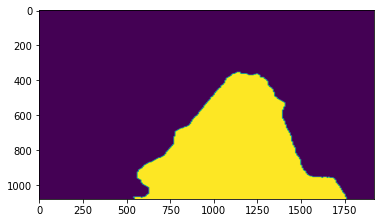

In [439]:
plt.imshow(mask)

In [440]:
thresholded_mask = cv2.convertScaleAbs(mask)
contours, _ = cv2.findContours(thresholded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('number of contours:',len(contours))

number of contours: 1


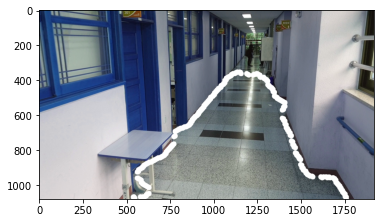

In [441]:
contour_areas = []   
for i, c in enumerate(contours):
    contour_areas.append(cv2.contourArea(c))
sorted_contours = sorted(zip(contour_areas, contours), key=lambda x:x[0], reverse=True)
biggest_contour= sorted_contours[0][1]
contour_image = cv2.drawContours(np.array(img), biggest_contour, -1, (255, 255, 255), 30)
plt.imshow(contour_image)

(-0.5, 1919.5, 1079.5, -0.5)

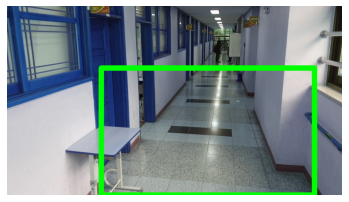

In [442]:
x,y,w,h = cv2.boundingRect(biggest_contour)
box_image = cv2.rectangle(np.array(img), (x,y), (x+w, y+h), (0, 255,0), 30)
plt.imshow(box_image)
plt.axis('off')

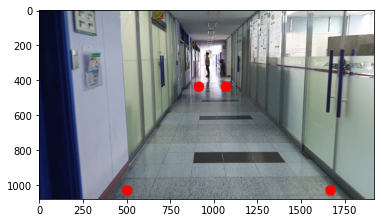

In [479]:
img = cv2.imread(img_path)
points = find_points(mask=mask)
for point in points:
    cv2.circle(img, (point[1], point[0]), 30, (255, 0 ,0), -1)
plt.imshow(img)

In [480]:
depth = abs(depth-depth[img.shape[0]-1][1000])

In [481]:
P = Projection(img.shape[0]/2,img.shape[1]/2,1000,1000,1)
#point_clouds = P.run(mask,depth)
#X,Y,Z = [i[0] for i in point_clouds],[i[1] for i in point_clouds],[i[2] for i in point_clouds]

In [489]:
pts1 = []
for point in points:
    pts1.append((point[1],point[0]))
pts2 = []
for point in points:
    x,y,z= P.match_point(point[0],point[1],depth=depth)
    pts2.append((1000+y,1200-z))
pts1,pts2 = np.float32(pts1),np.float32(pts2)
matrix = cv2.getPerspectiveTransform(pts1,pts2)

In [490]:
result_img = cv2.warpPerspective(img,matrix,(2000,1000))
result_mask = cv2.warpPerspective(mask,matrix,(2000,1000))

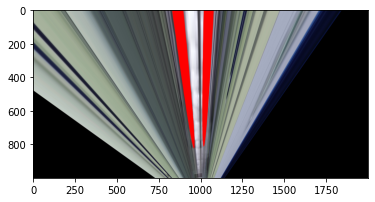

In [491]:
plt.imshow(result_img)

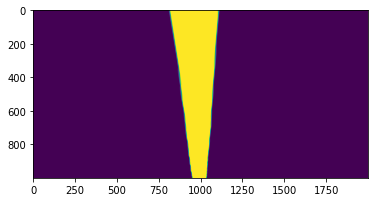

In [485]:
plt.imshow(result_mask)